# Graph Measures

In this section we'll cover some common network analysis techniques. This doesn't cover everything NetworkX is capable of, but is a should get you started exploring the rest of the package.

First we are going to need import some other packages.

In [2]:
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt

This is a little jupyter magic ([literally](https://ipython.org/ipython-doc/3/interactive/tutorial.html#magics-explained)], to make sure plots show up in the notebook.

In [3]:
%matplotlib inline

## Degree Distribution

A common feature of complex networks it's their degree distribution. This is often represented as degree rank plot. Let's check out the degree rank plot of a BA Graph.

In [4]:
BA = nx.barabasi_albert_graph(10000,1)

To get the correct degree sequence, we need to get the degrees sorted in descending order. Most NetworkX functions return a dictionary, with the keys being the nodes (or edges) and the values being the result of whatever measure you are running. So we want to sort the values in reverse order.

In [6]:
degrees = BA.degree()
degree_sequence = sorted(degrees.values(),reverse=True)

We could do this in one line if we wanted...

In [7]:
degree_sequence = sorted(BA.degree().values(),reverse=True)

Now we need to do some plotting. Plotting using matplotlib is a lot like plotting using MATLAB. Because the degree distribution of a BA graph is a power-law, we'd like to use a plot with log scales. Here is how we'd do it.

(0.9, 10001)

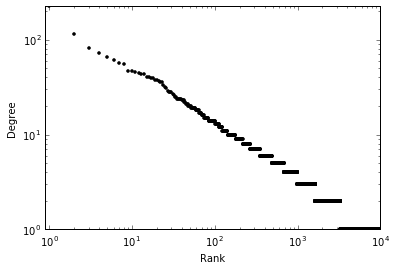

In [8]:
# loglog tells matplotlib to use log scales.
# The x values, range(1,10001), are the ranks, 
# and the degree_sequence are the y values.
# The String 'k.' means use black (k) dots (.)
plt.loglog(range(1,BA.order()+1),degree_sequence,'k.')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.ylim(1,max(degree_sequence)+1)
plt.xlim(.9,10001)

Matplotlib is a powerful tool more info can be found on using it [here](http://matplotlib.org/users/beginner.html).

### Degree Distribution of models

In the original paper where the Barabási–Albert model was introduced it was stated that it provided a good explanation for the Autonomous Sytems Network. Let's build a network with similar degree structure to a recent snapshot of the Autonomous Systems Network. The data was retrieved from [UCLA's Internet Research Lab's Topology Data](http://irl.cs.ucla.edu/topology/).

First, read in the network, it is in the data folder labeled `AS2013Sep.pickle`

In [9]:
AS = nx.read_gpickle('./data/AS2013Sep.pickle')

Let's find out the number of nodes and edges in the networks, and the average degree of the network

In [10]:
AS.order(),AS.size(),(2.0*AS.size())/AS.order()

(45765, 181365, 7.925925925925926)

Let's use these values as approximates to create a BA graph of the same size with almost the same number of edges

In [11]:
BA = nx.barabasi_albert_graph(#Fill in the rest AS.order(),8)

### Exercise

Find the degree sequence of each, and use the code below to plot each. Is this a good model?

In [ ]:
BA_deg_seq = #
AS_deg_seq = #

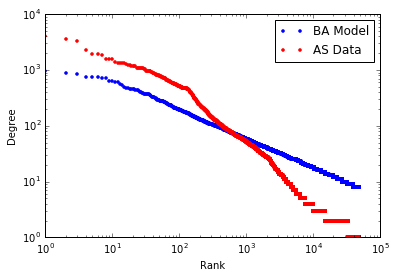

In [229]:
plt.loglog(BA_deg_seq,'b.',label='BA Model')
plt.loglog(AS_deg_seq,'r.',label='AS Data')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.legend()

#### A note on power laws. 

It is oftern claimed that networks have power-law degree distribution. That is the probability of degree k is proportional to 

$$Pr[k] \sim \frac{1}{k^\alpha}$$

Where, $\alpha$ is some constant. Often this is claimed pased on linear regressions of degree/rank plots. However, the appropriate way to fit power-laws is using maximum likelihood techniques. See [1] for more info

[1] Clauset, Aaron, Cosma Rohilla Shalizi, and Mark EJ Newman. "Power-law distributions in empirical data." _SIAM review_ 51.4 (2009): 661-703.

## Centrality

Identifying important nodes is often a common technique in complex network analysis. Degree is a simple measure of centrality, but there are many others. Let's explore a few on some real data on Terrorists in Colonial America. I wish I could claim I came up with this, but I didn't all credit goes to 

[1] http://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/

[2] Fischer, David Hackett. Historians' fallacies: Toward a logic of historical thought. Vol. 1970. London: Routledge & Kegan Paul, 1971.

The data file contains a graph with two types of nodes, 'Organization' and 'Person'. Organizations are different groups who met in colonial America and supported independence from England. People are people attending those meetings. First let's read the file

In [12]:
G = nx.read_gpickle('./data/Revolutionaries.gpickle')

Let's Check out the edges

In [14]:
G.edges()

[('GeorgeTrott', 'LoyalNine'),
 ('EdwardDolbear', 'LondonEnemies'),
 ('EdwardDolbear', 'BostonCommittee'),
 ('WilliamRussell', 'TeaParty'),
 ('ThomasHunstable', 'LondonEnemies'),
 ('ThomasHunstable', 'BostonCommittee'),
 ('JosephEaton', 'TeaParty'),
 ('RobertSessions', 'TeaParty'),
 ('LoyalNine', 'JohnAvery'),
 ('LoyalNine', 'CalebHopkins'),
 ('LoyalNine', 'ThomasChase'),
 ('LoyalNine', 'JohnSmith'),
 ('LoyalNine', 'AdamCollson'),
 ('LoyalNine', 'HenryWelles'),
 ('LoyalNine', 'CalebDavis'),
 ('LoyalNine', 'HenryBass'),
 ('LoyalNine', 'NathanielHitchborn'),
 ('LoyalNine', 'WilliamGreenleaf'),
 ('SamuelDexter', 'LondonEnemies'),
 ('SamuelHobbs', 'NorthCaucus'),
 ('LongRoomClub', 'JohnAdams'),
 ('LongRoomClub', 'RoyallTyler'),
 ('LongRoomClub', 'SamuelPhillips'),
 ('LongRoomClub', 'JosephWarren'),
 ('LongRoomClub', 'JosiahQuincy'),
 ('LongRoomClub', 'EbenHancock'),
 ('LongRoomClub', 'PaulRevere'),
 ('LongRoomClub', 'SamuelAdams'),
 ('LongRoomClub', 'BenjaminChurch'),
 ('LongRoomClub', 'Ja

We can see that the edges are between people and organizations. We are curious about the connections between people. We could write a function to create a new graph in which two people are connected if they co-attend a meeting, and the edge has a weight indicates the number of meetings they both attended. But that sounds hard, luckily NetworkX can do it for us. First let's make a list of nodes for organizations and people.

In [15]:
orgs = [n for n in G.nodes() if G.node[n]['type']=='Organization']
people = [n for n in G.nodes() if G.node[n]['type']=='Person']

Now we can use that handy function

In [20]:
O = nx.bipartite.weighted_projected_graph(G,orgs) # Connections between people based on co-meeting attendence
R = nx.bipartite.weighted_projected_graph(G,people) # Overlap among meeting attendees

We can use a quick python trick to determine who has the highest degree. Adding the keyword wight indicates that we should use _weighted_ edges.

In [18]:
deg = R.degree(weight='weight')
sorted(deg.items(), # Look at all the degrees as a tuple (node,degree)
       key=lambda i: i[1], # Sort the list by the second item in the tuple
       reverse=True)[:5] # Reverse the list (highest degree first), and only give the first 5

[('PaulRevere', 294),
 ('NathanielBarber', 251),
 ('WilliamCooper', 251),
 ('JohnHoffins', 251),
 ('WilliamGreenleaf', 238)]

Another important measure of centrality is the betweenneess centrality

In [19]:
btw = nx.betweenness_centrality(R,weight='weight')
sorted(btw.items(),
       key=lambda i: i[1],
       reverse=True)[:5]

[('PaulRevere', 0.10569232954134766),
 ('ThomasUrann', 0.073477249994178),
 ('JosephWarren', 0.05105029194128703),
 ('SamuelPeck', 0.04049453565036781),
 ('WilliamGreenleaf', 0.024984397850401206)]

Try plotting the betweenness centrality vs the degree for each node. Instead of using `plt.loglog`, use `plt.semilogy`

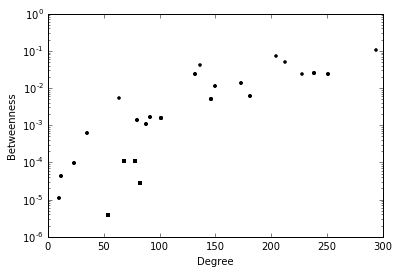

### Exercise

Do a similar analysis with the network of oranizations `O`, which is organziation is most central to the revolution?

First calculate the degree and betweenness for each of the nodes

In [78]:
deg = O.degree()
btw = nx.betweenness_centrality(O)

Since the number of organizations is small, it might not be the worst idea to draw the network. Here is a Red, White and Blue network drawing...

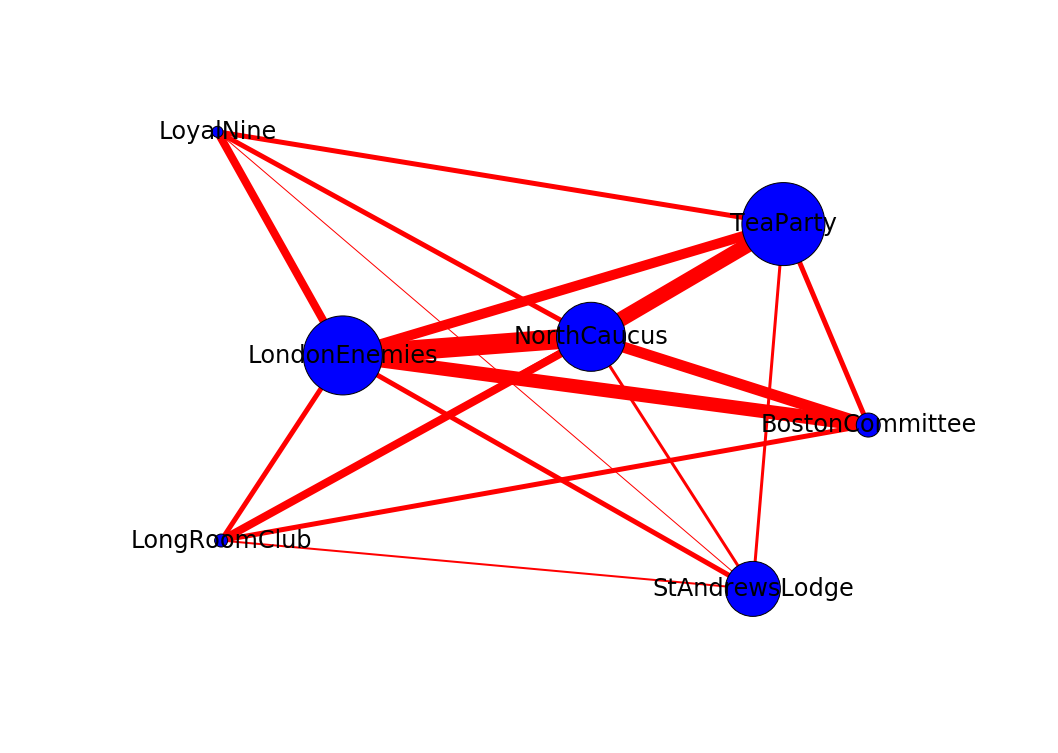

In [23]:
size = [G.degree(org)**2 for org in O.nodes()]
width = [d['weight'] for (u,v,d) in O.edges(data=True)]

plt.figure(figsize=(14,10)) #We'll make it bigger
nx.draw(M, width=width,
           with_labels=True,
           edge_color='r',
           node_color='b',
           node_size=size,
           font_size=24)

[('LondonEnemies', 6),
 ('TeaParty', 6),
 ('NorthCaucus', 6),
 ('LongRoomClub', 5),
 ('StAndrewsLodge', 5),
 ('LoyalNine', 4),
 ('BostonCommittee', 4)]

[('LondonEnemies', 0.05555555555555555),
 ('TeaParty', 0.05555555555555555),
 ('NorthCaucus', 0.05555555555555555),
 ('LongRoomClub', 0.016666666666666666),
 ('StAndrewsLodge', 0.016666666666666666),
 ('LoyalNine', 0.0),
 ('BostonCommittee', 0.0)]

## Phase Transitions

Some random graph models experience phase transitions like other physical phenomona. For example, the Erdos-Renyi graph that we already explored experiences a phase transition in the size of the giant connected component when the average degree of the model cross a certain threshold. We are going to use NetworkX to explore that threshold. 

Recall that an Erdos-Renyi random graph is one where there is an edge between each node with probability $p$. The ER model has expected number of Edges $\mathbb{E}[|E|]={n \choose 2}p$. With a little math on the degree distribution, we can find that the average degree will be $k=np$, and $p=\frac{k}{n}$.

The giant component is defined as the largest connected component in the graph. Let's explore how the size of the giant component changes for a graph of size 100, as we incrase the average degree.

In [24]:
n = 100
ks = np.arange(.1,3,.02)
GCC_size = []
for k in ks:
    G = nx.gnp_random_graph(n,k/n)
    GC = sorted(nx.connected_component_subgraphs(G),key=lambda C: len(C),reverse=True)[0]
    GCC_size.append(float(len(GC))/n)

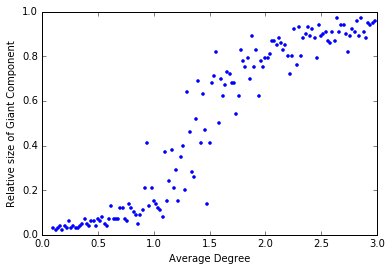

In [25]:
plt.plot(ks,GCC_size,marker='.',lw=0)
plt.xlabel('Average Degree')
plt.ylabel('Relative size of Giant Component')

Looks pretty messy. This is because each graph is a random instance. Let's make 50 graphs for each possible average degree.

In [26]:
N = 50 # Number of times to create a graph
n = 100 # Graph Size
ks = np.arange(.1,3,.1) # A bunch of average degrees, separated by .1 from .1 to 3
GCC_size = [] #List to store the size of the giant component
for k in ks:
    GCs = []
    for _ in range(N):
        G = nx.gnp_random_graph(n,k/n) #generate teh graph
        GC = sorted(nx.connected_component_subgraphs(G),key=lambda C: len(C),reverse=True)[0] #graph teh largest component
        GCs.append(float(len(GC))/n) # Measure it's size
    GCC_size.append(np.mean(GCs)) # Take the average and append it to the list

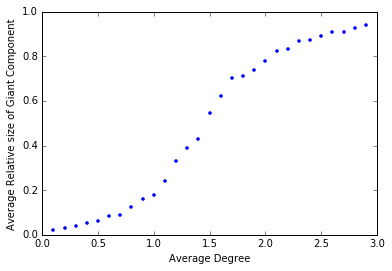

In [27]:
plt.plot(ks,GCC_size,marker='.',lw=0)
plt.xlabel('Average Degree')
plt.ylabel('Average Relative size of Giant Component')

Now let's test it for various values of $n$

10
50
100
250
500


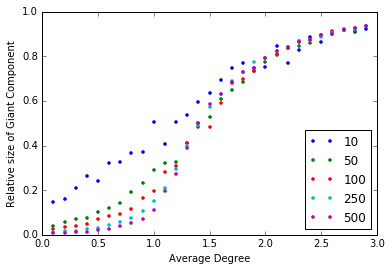

In [28]:
ks = np.arange(.1,3,.1)
N = 50
for n in [10,50,100,250,500]:
    print(n)
    GCC_size = []
    for k in ks:
        GCs = []
        for _ in range(N):
            G = nx.gnp_random_graph(n,k/n)
            GC = sorted(nx.connected_component_subgraphs(G),key=lambda C: len(C),reverse=True)[0]
            GCs.append(float(len(GC))/n)
        GCC_size.append(np.mean(GCs))
    plt.plot(ks,GCC_size,marker='.',label=str(n),lw=0)
plt.legend(loc='lower right')
plt.xlabel('Average Degree')
plt.ylabel('Relative size of Giant Component')

Notice how the transition gets sharper as $n$ gets larger.

## Community Detection

Determining different node types solely from network data is one of the most powerful tools in network analysis. NetworkX has limited capacity for community detection, but some new algorithms are coming with version 2.0. I've included one function here in the tutorial

In [29]:
import community

The first is a classic algorithm due to Girvan-Newman. It progressively removes the highest betweenness edges from a graph until graph becomes disconnected. Then it repeateds the process into successively smaller groups. Let's test it on a generated graph we know has two communities.

A connected caveman graph is a graph with $k$ complete graphs connected in a ring.

In [30]:
G = nx.connected_caveman_graph(2,10)

In [31]:
group1 = range(10)
group2 = range(10,20)

Let's see what partitions Girvan Newman can partition the graph correctly

In [32]:
comm = community.girvan_newman(G)

`comm` will have the breakdown of the graph at each stage of the algorithm, so the first item in the list is the graph broken into two parts.

In [33]:
comm[0]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

### Excercose

Now you try with the karate club graph

In [34]:
KC = nx.karate_club_graph()

Let's see how the algorithm did on identifying different groups. In the Karate Club Graph, nodes have an attribute `club` which is the group affiliatino and is either `Mr. Hi` or `Officer`.

In [220]:
KC.nodes(data=True)

[(0, {'club': 'Mr. Hi'}),
 (1, {'club': 'Mr. Hi'}),
 (2, {'club': 'Mr. Hi'}),
 (3, {'club': 'Mr. Hi'}),
 (4, {'club': 'Mr. Hi'}),
 (5, {'club': 'Mr. Hi'}),
 (6, {'club': 'Mr. Hi'}),
 (7, {'club': 'Mr. Hi'}),
 (8, {'club': 'Mr. Hi'}),
 (9, {'club': 'Officer'}),
 (10, {'club': 'Mr. Hi'}),
 (11, {'club': 'Mr. Hi'}),
 (12, {'club': 'Mr. Hi'}),
 (13, {'club': 'Mr. Hi'}),
 (14, {'club': 'Officer'}),
 (15, {'club': 'Officer'}),
 (16, {'club': 'Mr. Hi'}),
 (17, {'club': 'Mr. Hi'}),
 (18, {'club': 'Officer'}),
 (19, {'club': 'Mr. Hi'}),
 (20, {'club': 'Officer'}),
 (21, {'club': 'Mr. Hi'}),
 (22, {'club': 'Officer'}),
 (23, {'club': 'Officer'}),
 (24, {'club': 'Officer'}),
 (25, {'club': 'Officer'}),
 (26, {'club': 'Officer'}),
 (27, {'club': 'Officer'}),
 (28, {'club': 'Officer'}),
 (29, {'club': 'Officer'}),
 (30, {'club': 'Officer'}),
 (31, {'club': 'Officer'}),
 (32, {'club': 'Officer'}),
 (33, {'club': 'Officer'})]

Create two lists, one with all the nodes who are members of Mr. Hi's group and those that are members of Officer's group

In [ ]:
mrHi = #
officer = #

Compare them to the divisions found by the algorithm.

In [222]:
sorted(comm[0][0]),sorted(mrHi)

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21])

In [223]:
sorted(comm[0][1]),sorted(officer)

([2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

Since this graph isn't that large, we could actually plot it. We'll make the first found community red, and the second community blue. If the nodes are misclassified we'll put a thick border around them.

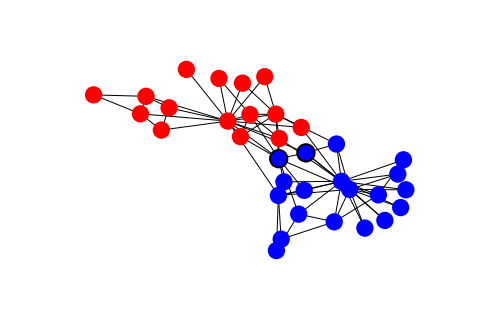

In [224]:
colors = []
for n in KC.nodes():
    if n in comm[0][0]:
        colors.append('r')
    else:
        colors.append('b')
lwidths = []
for n in KC.nodes():
    if n in comm[0][0] and n in mrHi:
        lwidths.append(0)
    elif n in comm[0][1] and n in officer:
        lwidths.append(0)
    else:
        lwidths.append(2)
nx.draw(KC,node_color=colors,linewidths=lwidths)